In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
!export CUDA_LAUNCH_BLOCKING=1

In [3]:
import os
import shutil
import random
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor, Compose, Resize, Normalize

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# from xception import Xception

In [4]:
random_seed = 42
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [7]:
mask_list = sorted(os.listdir('./4.SoftExudates/'))
for mask in mask_list:
    if mask == '.DS_Store':
        mask_list.remove(mask)
    img = cv2.imread('./4.SoftExudates/' + mask)
    img[img > 0] = 1
    cv2.imwrite('./4.SoftExudates/' + mask, img)

print(len(sorted(os.listdir('./4.SoftExudates/'))))

1291


In [8]:
# background, disc, cup, hemorrhage, exudate
class_colors = [(0, 0, 0), (255, 0, 0), (255, 0, 255), (0, 255, 0), (255, 255, 0)]

def colorize_mask(mask):
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(5):
        colored_mask[mask == i] = class_colors[i]
    return colored_mask

# Xception

## Separable Convolution

In [9]:
def fixed_padding(inputs, kernel_size, rate):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs

class SeparableConvoluton(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, dilation=1, bias=False):
        super(SeparableConvoluton, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size, stride, 0, dilation, groups=in_planes, bias=bias)
        self.pointwise = nn.Conv2d(in_planes, out_planes, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = fixed_padding(x, self.conv1.kernel_size[0], rate=self.conv1.dilation[0])
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

## Block

In [10]:
class Block(nn.Module):
    # reps(몇 번 반복할지, entry flow에서는 1번(입력2), middle flow에서는 2번(입력3)), grow_firs & is_last(블록마다 확인하여 설정)
    def __init__(self, in_planes, out_planes, reps, stride=1, dilation=1, start_with_relu=True, grow_first=True, is_last=True):
        super(Block, self).__init__()

        # skip connection
        if out_planes != in_planes or stride != 1:
            self.skip = nn.Conv2d(in_planes, out_planes, 1, stride=stride, bias=False)
            self.skipbn = nn.BatchNorm2d(out_planes)
        else:
            self.skip = None

        self.relu = nn.ReLU(inplace=True)
        rep = []

        # entry flow & middel flow
        filters = in_planes # 필터 개수를 맞추기 위함
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConvoluton(in_planes, out_planes, 3, stride=1, dilation=dilation))
            rep.append(nn.BatchNorm2d(out_planes))
            filters = out_planes

        # 반복
        for _ in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConvoluton(filters, filters, 3, stride=1, dilation=dilation))
            rep.append(nn.BatchNorm2d(filters))

        # entry flow에서 사용
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConvoluton(in_planes, out_planes, 3, stride=1, dilation=dilation))
            rep.append(nn.BatchNorm2d(out_planes))

        # relu가 시작이 아닐 경우 (entry flow에서 사용)
        if not start_with_relu:
            rep = rep[1:]

        if stride != 1: # 각 블록에서 마지막에 stride가 2일 경우
            rep.append(SeparableConvoluton(out_planes, out_planes, 3, stride=2))

        if stride == 1 and is_last: # exit flow의 마지막에 사용
            rep.append(SeparableConvoluton(out_planes, out_planes, 3, stride=1))

        self.rep = nn.Sequential(*rep)

    def forward(self, input):
        x = self.rep(input)

        # skip connection
        if self.skip is not None:
            skip = self.skip(input)
            skip = self.skipbn(skip)
        else:
            skip = input

        x += skip

        return x

## Modified Aligned Xception

In [11]:
class Xception(nn.Module):
    def __init__(self, in_planes=3, os=16):
        super(Xception, self).__init__()

        if os == 16:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
        elif os == 8:
            entry_block3_stride = 1
            middle_block_rate = 2
            exit_block_rates = (2, 4)
        else:
            raise NotImplementedError

        # Entry Flow
        self.conv1 = nn.Conv2d(in_planes, 32, 3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        self.block1 = Block(64, 128, reps=2, stride=2, start_with_relu=False)
        self.block2 = Block(128, 256, reps=2, stride=2, start_with_relu=True, grow_first=True)
        self.block3 = Block(256, 728, reps=2, stride=entry_block3_stride, start_with_relu=True, grow_first=True, is_last=True)

        # Middle Flow
        self.block4  = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block5  = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block6  = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block7  = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block8  = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block9  = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block10 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block11 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block12 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block13 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block14 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block15 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block16 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block17 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block18 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)
        self.block19 = Block(728, 728, reps=3, stride=1, dilation=middle_block_rate, start_with_relu=True, grow_first=True)

        # Exit Flow
        self.block20 = Block(728, 1024, reps=2, stride=1, dilation=exit_block_rates[0], start_with_relu=True, grow_first=False, is_last=True)

        self.conv3 = SeparableConvoluton(1024, 1536, 3, stride=1, dilation=exit_block_rates[1])
        self.bn3 = nn.BatchNorm2d(1536)

        self.conv4 = SeparableConvoluton(1536, 1536, 3, stride=1, dilation=exit_block_rates[1])
        self.bn4 = nn.BatchNorm2d(1536)

        self.conv5 = SeparableConvoluton(1536, 2048, 3, stride=1, dilation=exit_block_rates[1])
        self.bn5 = nn.BatchNorm2d(2048)

        # Init weights
        self._init_weight()

    def forward(self, x):
        # Entry Flow
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.block1(x)
        # low_level_features: block1의 결과값으로, deeplabv3+ 구조에서 사용
        low_level_features = x
        x = self.block2(x)
        x = self.block3(x)

        # Middle Flow
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        x = self.block13(x)
        x = self.block14(x)
        x = self.block15(x)
        x = self.block16(x)
        x = self.block17(x)
        x = self.block18(x)
        x = self.block19(x)

        # Exit Flow
        x = self.block20(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)

        return x, low_level_features

    def _init_weight(self):
        for m in self.modules():
            # modules에서 각 레이어가 Conv2d이면 weight를 초기화, BatchNorm2d이면 weight를 1로, bias를 0으로 초기화
            if isinstance(m, nn.Conv2d): # isinstance(확인하고자 하는 데이터 값, 확인하고자 하는 데이터 타입), 서로 타입이 같으면 True, 아니면 False
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight) # input tensor가 He초기값으로 N(0,std^2)의 정규분포를 갖는다.
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

# Deeplabv3plus

## ASPP

In [12]:
class ASPP(nn.Module):
    def __init__(self, in_planes, out_planes, rate):
        super(ASPP, self).__init__()
        if rate == 1:
            kernel_size = 1
            padding = 0
        else:
            kernel_size = 3
            padding = rate

        self.atrous_convolution = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=1, padding=padding, dilation=rate, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU()

        self.__init_weight()

    def forward(self, x):
        x = self.atrous_convolution(x)
        x = self.bn(x)
        x = self.relu(x)

        return x

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

## encoder-decoder & architecture

In [26]:
class Encoder(nn.Module):
    def __init__(self, in_planes, os):
        super(Encoder, self).__init__()

        self.xception_features = Xception(in_planes, os)

        if os == 16:
            rates = [1, 6, 12, 18]
        elif os == 8:
            rates = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        # ASPP
        self.aspp1 = ASPP(2048, 256, rate=rates[0])
        self.aspp2 = ASPP(2048, 256, rate=rates[1])
        self.aspp3 = ASPP(2048, 256, rate=rates[2])
        self.aspp4 = ASPP(2048, 256, rate=rates[3])

        self.relu = nn.ReLU()

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(2048, 256, 1, stride=1, bias=False),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU())

        self.conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(256)



        self.__init_weight()

    def forward(self, x):
        x, low_level_features = self.xception_features(x)

        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.upsample(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        return x, low_level_features
    
    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    
class Decoder(nn.Module):
    def __init__(self, in_planes, n_classes, recon=False):
        super(Decoder, self).__init__()

        self.conv2 = nn.Conv2d(256, 48, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(48)
        self.relu = nn.ReLU()

        if recon:
            self.last_conv = nn.Sequential(nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.Conv2d(256, in_planes, kernel_size=1, stride=1))
        else:
            self.last_conv = nn.Sequential(nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.Conv2d(256, n_classes, kernel_size=1, stride=1))

        self.__init_weight()

    def forward(self, x, low_level_features):

        x = F.upsample(x, size=(int(math.ceil(input.size()[-2]/4)),
                                int(math.ceil(input.size()[-1]/4))),
                                mode='bilinear', align_corners=True) # x upsample
        
        low_level_features = self.conv2(low_level_features)
        low_level_features = self.bn2(low_level_features)
        low_level_features = self.relu(low_level_features)

        x = torch.cat((x, low_level_features), dim=1)
        x = self.last_conv(x)
        x = F.upsample(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x
    
    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    
class DeepLabv3plus(nn.Module):
    def __init__(self, n_classes, in_planes=3, recon=False, os=16):
        super(DeepLabv3plus, self).__init__()

        self.encoder = Encoder(in_planes, os)
        self.decoder = Decoder(in_planes, n_classes, recon=recon)

        self.__init_weight()

    def forward(self, x):
        x, low_level_features = self.encoder(x)
        x = self.decoder(x, low_level_features)

        return x

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [27]:
model = DeepLabv3plus(num_classes=2, in_planes=3, os=16)
model

DeepLabv3plus(
  (encoder): Encoder(
    (xception_features): Xception(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (block1): Block(
        (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (rep): Sequential(
          (0): SeparableConvoluton(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
            (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (1): BatchNorm2d(128,

# SSMD Deeplabv3plus

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_planes, os):
        super(Encoder, self).__init__()

        self.xception_features = Xception(in_planes, os)

        if os == 16:
            rates = [1, 6, 12, 18]
        elif os == 8:
            rates = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        # ASPP
        self.aspp1 = ASPP(2048, 256, rate=rates[0])
        self.aspp2 = ASPP(2048, 256, rate=rates[1])
        self.aspp3 = ASPP(2048, 256, rate=rates[2])
        self.aspp4 = ASPP(2048, 256, rate=rates[3])

        self.relu = nn.ReLU()

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(2048, 256, 1, stride=1, bias=False),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU())

        self.conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(256)

        self.__init_weight()

    def forward(self, x):
        x, low_level_features = self.xception_features(x)

        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.upsample(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        return x, low_level_features
    
    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    
class Decoder(nn.Module):
    def __init__(self, in_planes, n_classes, recon=False):
        super(Decoder, self).__init__()

        self.conv2 = nn.Conv2d(256, 48, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(48)
        self.relu = nn.ReLU()

        if recon:
            self.last_conv = nn.Sequential(nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                           nn.BatchNorm2d(256),
                                           nn.ReLU(),
                                           nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                           nn.BatchNorm2d(256),
                                           nn.ReLU(),
                                           nn.Conv2d(256, in_planes, kernel_size=1, stride=1))
        else:
            self.last_conv = nn.Sequential(nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU(),
                                             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU(),
                                             nn.Conv2d(256, n_classes, kernel_size=1, stride=1))


        self.__init_weight()

    def forward(self, x, low_level_features):
        x = F.upsample(x, size=(int(math.ceil(input.size()[-2]/4)),
                                int(math.ceil(input.size()[-1]/4))),
                                mode='bilinear', align_corners=True) # x upsample
        
        low_level_features = self.conv2(low_level_features)
        low_level_features = self.bn2(low_level_features)
        low_level_features = self.relu(low_level_features)

        x = torch.cat((x, low_level_features), dim=1)
        x = self.last_conv(x)
        x = F.upsample(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x
    
    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    
class SSMDDeepLabv3plus(nn.Module):
    def __init__(self, n_classes, in_planes=3, os=16, supervised=False):
        super(DeepLabv3plus, self).__init__()

        self.encoder = Encoder(in_planes, os)
        self.reconstruction = Decoder(in_planes, n_classes=None, recon=True)

        self.microaneurysms = Decoder(in_planes, n_classes, recon=False)
        self.hemohedges = Decoder(in_planes, n_classes, recon=False)
        self.hardexudates = Decoder(in_planes, n_classes, recon=False)
        self.softexudates = Decoder(in_planes, n_classes, recon=False)

        self.supervised = supervised

        self.__init_weight()

    def forward(self, x):
        x, low_level_features = self.encoder(x)
        
        if self.supervised:
            x1 = self.microaneurysms(x, low_level_features)
            x2 = self.hemohedges(x, low_level_features)
            x3 = self.hardexudates(x, low_level_features)
            x4 = self.softexudates(x, low_level_features)
            return x, x1, x2, x3, x4
        else:
            x = self.reconstruction(x, low_level_features)
            return x

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

## Architecture

In [13]:
class DeepLabv3plus(nn.Module):
    def __init__(self, n_input_channels=3, n_classes=2, os=16, _print=True):
        if _print:
            print("Constructing DeepLabv3+ model...")
            print(f"Number of input channels: {n_input_channels}")
            print(f"Output stride: {os}")
            print(f"Number of classes: {n_classes}")
        super(DeepLabv3plus, self).__init__()

        # Atrous Convolution
        self.xception_features = Xception(n_input_channels, os) # Xception 객체 생성
        # ASPP # output stride가 16일 경우, rate는 1, 6, 12, 18 / output stride가 8일 경우, rate는 1, 12, 24, 36
        if os == 16:
            rates = [1, 6, 12, 18]
        elif os == 8:
            rates = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        # aspp의 rate별로 atrous convolution을 진행
        self.aspp1 = ASPP(2048, 256, rate=rates[0])
        self.aspp2 = ASPP(2048, 256, rate=rates[1])
        self.aspp3 = ASPP(2048, 256, rate=rates[2])
        self.aspp4 = ASPP(2048, 256, rate=rates[3])

        self.relu = nn.ReLU()

        # aspp와 함께 사용할 global average pooling
        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(2048, 256, 1, stride=1, bias=False),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU())

        # aspp의 결과물을 concat한 후 적용, 1x1 convolution을 통해 256개로 줄임
        self.conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(256)

        # adopt [1x1, 48] for channel reduction
        # low level feature를 1x1 convolution을 통해 48개로 줄임
        self.conv2 = nn.Conv2d(128, 48, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(48)

        # 마지막 1x1 convolution을 통해 class 개수만큼 output을 생성
        self.last_conv = nn.Sequential(nn.Conv2d(304, 256, 3, stride=1, padding=1, bias=False),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(256, 256, 3, stride=1, padding=1, bias=False),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                        nn.Conv2d(256, n_classes, 1, stride=1))

    def forward(self, input):
        x, low_level_features = self.xception_features(input) # xception의 결과값과 low level feature를 받음
        x1 = self.aspp1(x) # aspp 1~4를 통과
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x) # aspp와 함께 global average pooling을 통과
        x5 = F.upsample(x5, size=x4.size()[2:], mode='bilinear', align_corners=True) # x5의 크기를 x4와 같게 조정

        x = torch.concat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x) # aspp의 결과물을 concat한 후 1x1 convolution을 통과
        x = self.bn1(x)
        x = self.relu(x)
        x = F.upsample(x, size=(int(math.ceil(input.size()[-2]/4)),
                                int(math.ceil(input.size()[-1]/4))),
                                mode='bilinear', align_corners=True) # x upsample

        low_level_features = self.conv2(low_level_features) # low level feature를 1x1 convolution을 통과
        low_level_features = self.bn2(low_level_features)
        low_level_features = self.relu(low_level_features)

        x = torch.concat((x, low_level_features), dim=1) # x와 low level feature concat
        x = self.last_conv(x) # 마지막 1x1 convolution을 통과
        x = F.upsample(x, size=input.size()[2:], mode='bilinear', align_corners=True) # x의 크기를 input과 같게 조정

        return x


    def freeze_bn(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()


    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

if __name__ == "__main__":
    model = DeepLabv3plus(n_input_channels=3, n_classes=5, os=16, _print=True)
    model.eval()
    image = torch.randn(1, 3, 512, 512)
    with torch.no_grad():
        output = model.forward(image)
    print(output.size())

Constructing DeepLabv3+ model...
Number of input channels: 3
Output stride: 16
Number of classes: 5
torch.Size([1, 5, 512, 512])


# train

In [14]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [15]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(os.listdir(self.mask_dir))

    def __getitem__(self, idx):
        img_list = sorted(os.listdir(self.img_dir))
        image = cv2.imread(os.path.join(self.img_dir, img_list[idx]))
        image = self.preprocessing(image)
        image = image / 255

        mask_list = sorted(os.listdir(self.mask_dir))
        mask = cv2.imread(os.path.join(self.mask_dir, mask_list[idx]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (512, 512))

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
        return image, mask

    def preprocessing(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image[:, :, 0] = clahe.apply(image[:, :, 0])
        image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
        image = cv2.resize(image, (512, 512))
        return image

# train_dataset = CustomImageDataset(
#     img_dir='../LOOCUS-FUNDUS-AI/dataset/train/images',
#     mask_dir='../LOOCUS-FUNDUS-AI/dataset/train/masks',
#     transform=ToTensor(),
# )
train_dataset = CustomImageDataset(
    img_dir='/home/visuworks2019/Desktop/loocus/jaekyung/code/Original_Images',
    mask_dir='/home/visuworks2019/Desktop/loocus/jaekyung/code/Original_Images',
    transform=ToTensor(),
)

test_dataset = CustomImageDataset(
    img_dir='../LOOCUS-FUNDUS-AI/dataset/train/images',
    mask_dir='../LOOCUS-FUNDUS-AI/dataset/train/masks',
    transform=ToTensor(),
)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# unsupervised
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, recon_dir, transform=None):
        self.img_dir = img_dir
        self.recon_dir = recon_dir
        self.transform = transform
        # self.target_transform = target_transform

    def __len__(self):
        return len(os.listdir(self.mask_dir))

    def __getitem__(self, idx):
        img_list = sorted(os.listdir(self.img_dir))
        image = cv2.imread(os.path.join(self.img_dir, img_list[idx]))
        image = self.preprocessing(image)
        image = image / 255

        recon_list = sorted(os.listdir(self.mask_dir))
        recon = cv2.imread(os.path.join(self.mask_dir, recon_list[idx]), cv2.IMREAD_BGR2RGB)
        recon = cv2.resize(recon, (512, 512))
        recon = recon / 255

        if self.transform:
            image = self.transform(image)
            recon = self.target_transform(mask)
            
        return image, recon

    def preprocessing(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image[:, :, 0] = clahe.apply(image[:, :, 0])
        image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
        image = cv2.resize(image, (512, 512))
        return image

In [ ]:
# supervised
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, recon_dir, micro_dir, hemo_dir, hard_dir, soft_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.recon_dir = recon_dir
        self.micro_dir = micro_dir
        self.hemo_dir = hemo_dir
        self.hard_dir = hard_dir
        self.soft_dir = soft_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(os.listdir(self.mask_dir))

    def __getitem__(self, idx):
        img_list = sorted(os.listdir(self.img_dir))
        image = cv2.imread(os.path.join(self.img_dir, img_list[idx]))
        image = self.preprocessing(image)
        image = image / 255

        recon_list = sorted(os.listdir(self.mask_dir))
        recon = cv2.imread(os.path.join(self.mask_dir, recon_list[idx]), cv2.IMREAD_BGR2RGB)
        recon = cv2.resize(recon, (512, 512))
        recon = recon / 255

        micro_list = sorted(os.listdir(self.mask_dir))
        micro = cv2.imread(os.path.join(self.mask_dir, micro_list[idx]), cv2.IMREAD_GRAYSCALE)
        micro = cv2.resize(micro, (512, 512))

        hemo_list = sorted(os.listdir(self.mask_dir))
        hemo = cv2.imread(os.path.join(self.mask_dir, hemo_list[idx]), cv2.IMREAD_GRAYSCALE)
        hemo = cv2.resize(hemo, (512, 512))

        hard_list = sorted(os.listdir(self.mask_dir))
        hard = cv2.imread(os.path.join(self.mask_dir, hard_list[idx]), cv2.IMREAD_GRAYSCALE)
        hard = cv2.resize(hard, (512, 512))

        soft_list = sorted(os.listdir(self.mask_dir))
        soft = cv2.imread(os.path.join(self.mask_dir, soft_list[idx]), cv2.IMREAD_GRAYSCALE)
        soft = cv2.resize(soft, (512, 512))

        if self.transform:
            image = self.transform(image)
            recon = self.target_transform(mask)
        if self.target_transform:
            micro = self.target_transform(mask)
            hemo = self.target_transform(mask)
            hard = self.target_transform(mask)
            soft = self.target_transform(mask)
        return image, recon, micro, hemo, hard, soft

    def preprocessing(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image[:, :, 0] = clahe.apply(image[:, :, 0])
        image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
        image = cv2.resize(image, (512, 512))
        return image

In [ ]:
# unsupervised
transforms = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CustomImageDataset(
    img_dir='',
    recon_dir='',
    transform=transforms,
)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [ ]:
# supervised
transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

train_dataset = CustomImageDataset(
    img_dir='',
    recon_dir='',
    micro_dir='',
    hemo_dir = '',
    hard_dir = '',
    soft_dir = '',
    transform=transforms,
)

val_dataset = CustomImageDataset(
    img_dir='',
    recondir='',
    micro_dir='',
    hemo_dir = '',
    hard_dir = '',
    soft_dir = '',
    transform=transforms,
)

test_dataset = CustomImageDataset(
    img_dir='',
    recondir='',
    micro_dir='',
    hemo_dir = '',
    hard_dir = '',
    soft_dir = '',
    transform=transforms,
)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## unsupervised

In [16]:
model = DeepLabv3plus(n_input_channels=3, n_classes=None, os=16, supervised=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = nn.DataParallel(model)
model = model.to(device)

print('Start training..')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in tqdm(train_dataloader):
        images = images.to(device).float()
        masks = masks.to(device).long()
        outputs = model(images)

        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_dataloader):
            images = images.to(device).float()
            masks = masks.to(device).long()
            outputs = model(images)['out']

            loss = criterion(outputs, masks)
            val_loss += loss.item()

    early_stopping = EarlyStopping(train_loss, model)
    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_dataloader)}')

Constructing DeepLabv3+ model...
Number of input channels: 3
Output stride: 16
Number of classes: 2
Start training..


100%|██████████| 162/162 [01:18<00:00,  2.07it/s]

Epoch 1/1, Train Loss: 0.03706225452019063


In [ ]:
model.encoder.save_state_dict('encoder.pth')

## supervised

In [ ]:
# supervised, micro
model = DeepLabv3plus(n_input_channels=3, n_classes=2, os=16, supervised=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 150
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = nn.DataParallel(model)
model = model.to(device)
alpha = 0.2
beta = 0.8
print('Start training..')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, recon, micro, hemo, hard, soft in tqdm(train_dataloader):
        images = images.to(device).float()
        recon = recon.to(device).long()
        micro = micro.to(device).long()
        hemo = hemo.to(device).long()
        hard = hard.to(device).long()
        soft = soft.to(device).long()
        x, x1, x2, x3, x4 = model(images)

        x_loss = criterion(outputs, recon)
        x1_loss = criterion(x1, micro)
        x2_loss = criterion(x2, hemo)
        x3_loss = criterion(x3, hard)
        x4_loss = criterion(x4, soft)

        seg_loss = beta * x1_loss + (1-beta) * (x2_loss + x3_loss + x4_loss)
        ssmd_loss = alpha * x_loss + seg_loss
        
        optimizer.zero_grad()
        ssmd_loss.backward()
        optimizer.step()
        train_loss += ssmd_loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_dataloader):
            images = images.to(device).float()
            masks = masks.to(device).long()
            outputs = model(images)['out']

            loss = criterion(outputs, masks)
            val_loss += loss.item()

    early_stopping = EarlyStopping(train_loss, model)
    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_dataloader)}')

# eval

In [22]:
model.xception_features.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 3.8775e-02, -1.4232e-01, -2.0856e-01],
                        [ 1.8627e-01, -2.9764e-01, -4.4640e-01],
                        [-2.0776e-01, -1.3306e-01,  1.2155e-01]],
              
                       [[-3.7249e-01,  3.3957e-02, -3.5207e-01],
                        [ 4.0848e-02,  5.7545e-02,  2.8526e-01],
                        [ 3.6064e-02,  3.3057e-01, -3.6563e-01]],
              
                       [[-4.4276e-01, -6.4998e-02,  4.2589e-01],
                        [-2.7169e-01,  3.7753e-01, -2.0843e-01],
                        [ 4.2392e-01,  1.3089e-01,  1.9859e-01]]],
              
              
                      [[[ 3.1849e-01,  4.1884e-01, -2.2195e-01],
                        [-5.6660e-01,  3.1722e-01, -4.2007e-01],
                        [-5.5963e-02, -2.3460e-01,  1.1588e-01]],
              
                       [[ 3.7913e-01,  8.9039e-02, -4.7195e-02],
                        [-1.3502e-01,  3.0662

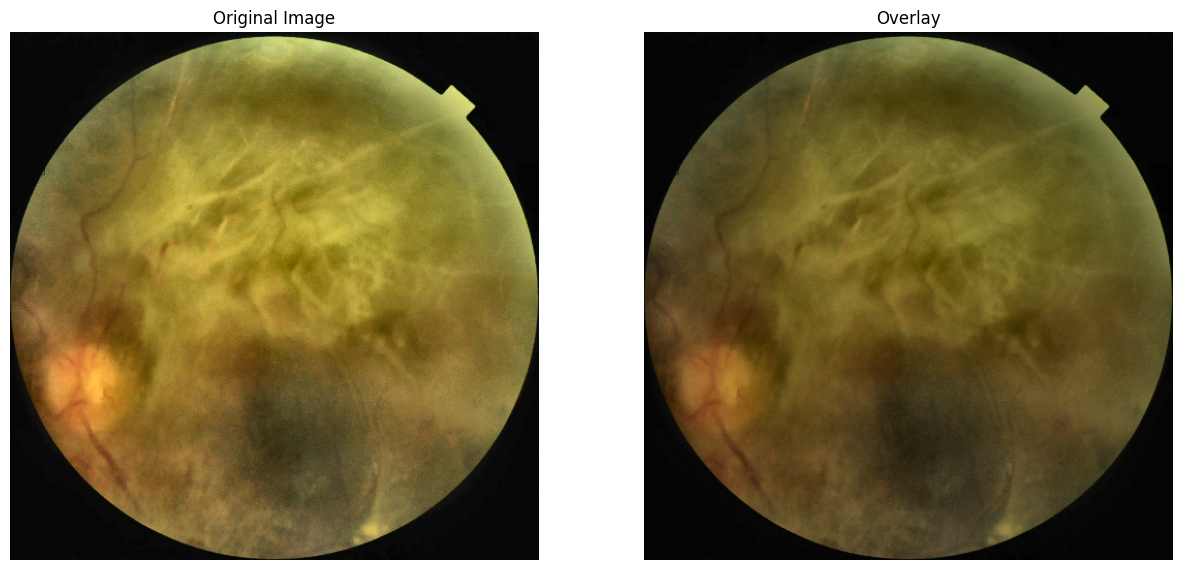

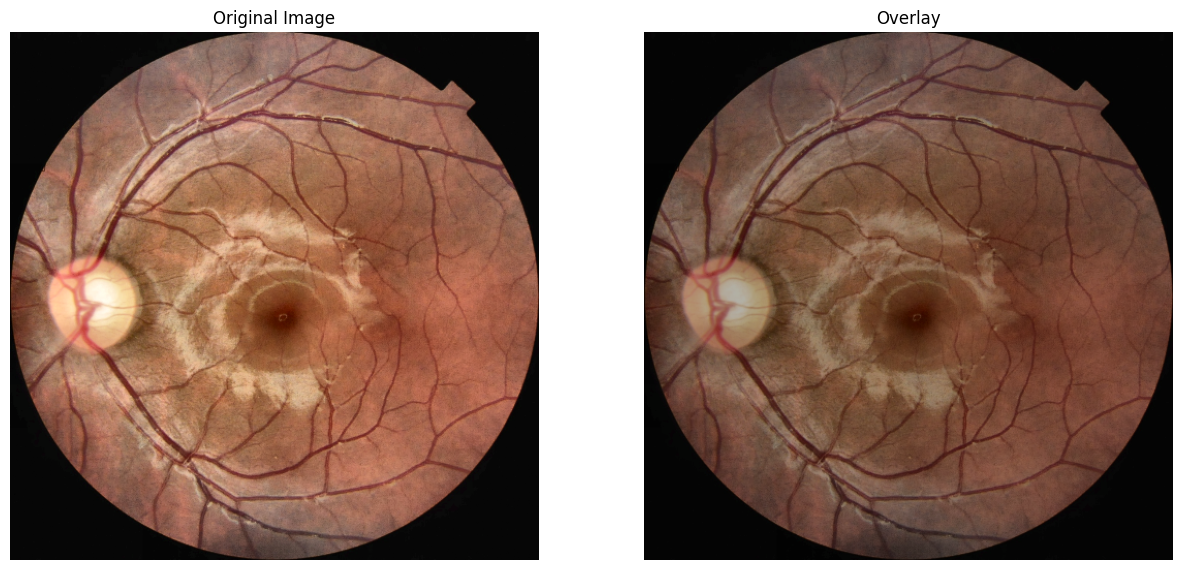

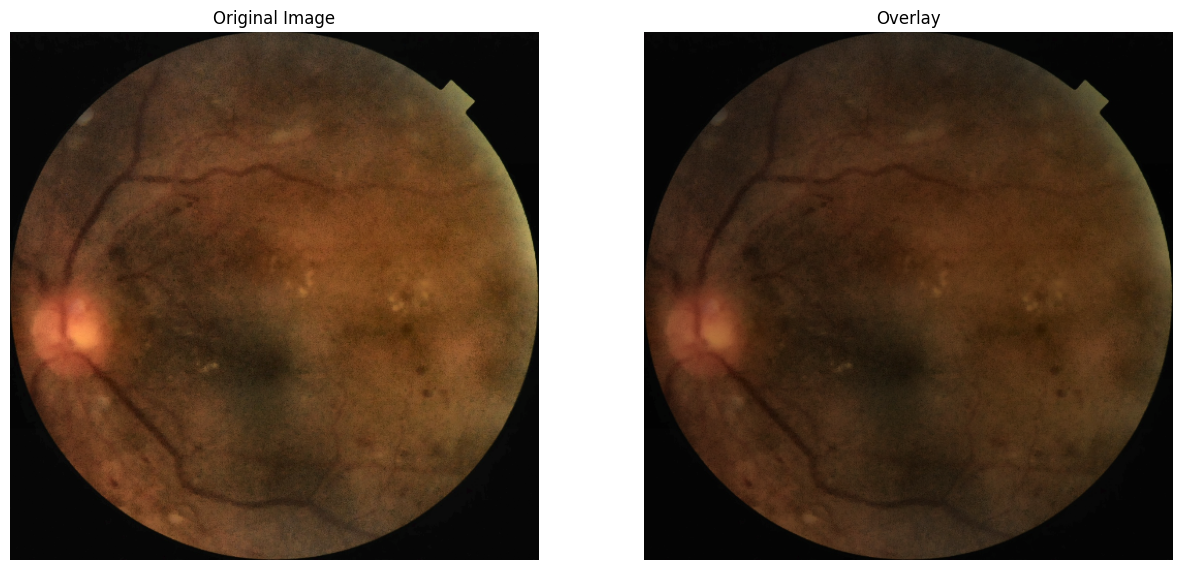

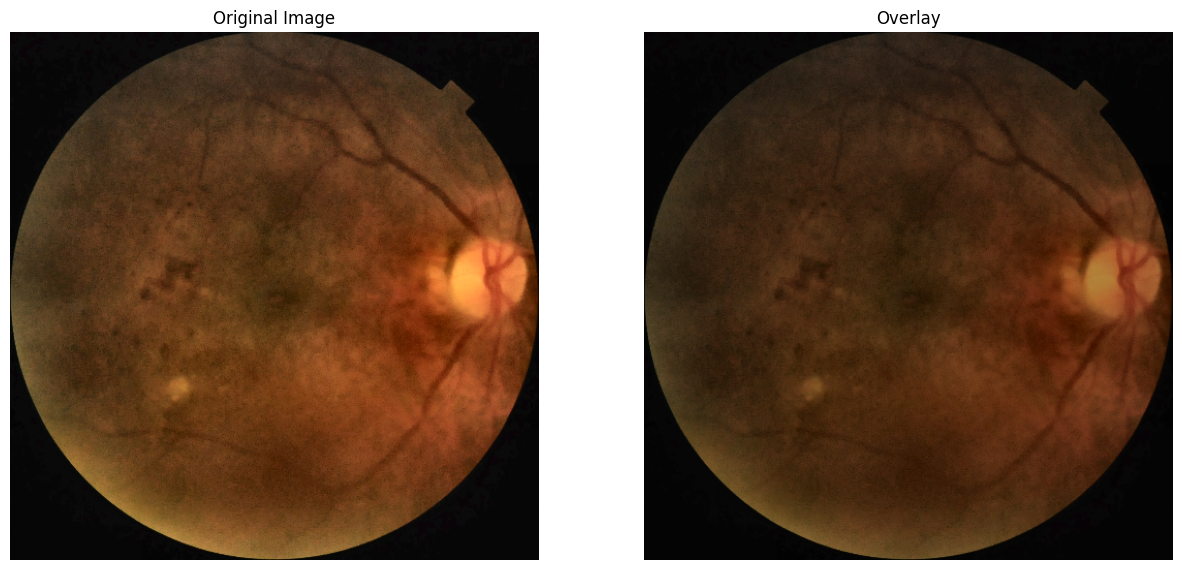

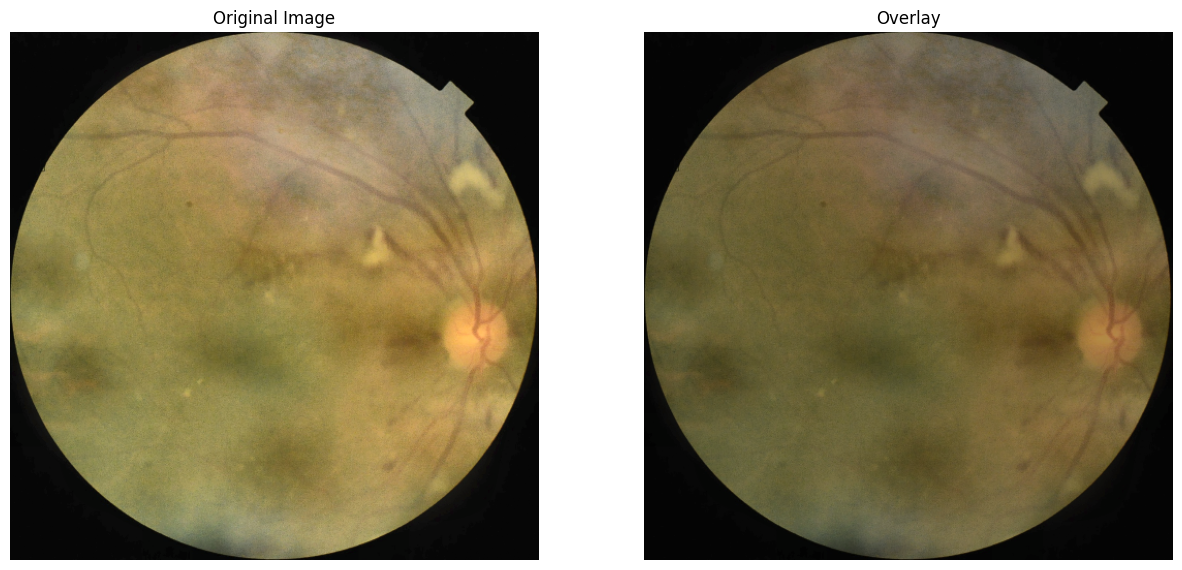

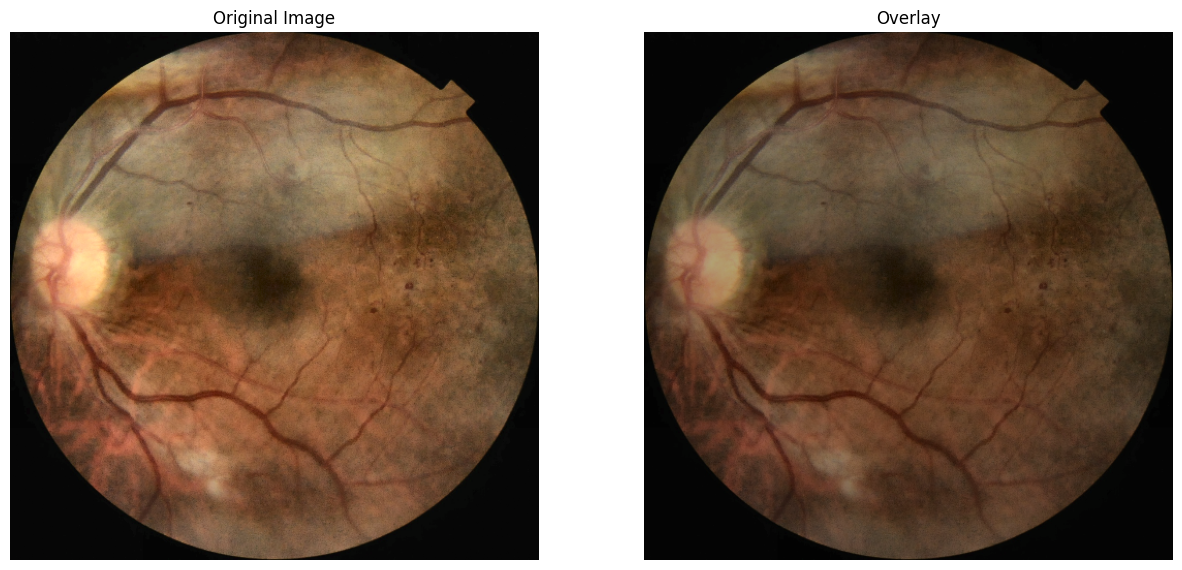

In [15]:
model = model.to(device)
model.eval()
with torch.no_grad():
    for i, (image, mask) in  enumerate(test_dataloader):
        if i > 5:
            break
        image = image.to(device).float()
        output = model(image)
        _, predicted = torch.max(output, 1)

        image = image[0].permute(1, 2, 0).cpu().numpy()
        mask = mask.squeeze()
        predicted = colorize_mask(predicted.cpu().squeeze()) 

        plt.figure(figsize=(15, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title('Original Image')

        # original image에 predicted mask를 overlay
        overlay = cv2.addWeighted(image, 0.7, predicted.astype(np.float32), 0.3, 0) # (np.float32)
        plt.subplot(1, 2, 2)
        plt.imshow(overlay)
        plt.axis('off')
        plt.title('Overlay')

        plt.show()